In [184]:
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

In [185]:
# Function to parse the date column
def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

# Load the dataset
dataset = read_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022copy3.csv', parse_dates={'Datetime': ['Tanggal']}, date_parser=parse)
dataset.drop('OriginTime', axis=1, inplace=True)
# Manually specify column names
dataset.columns = ['Datetime', 'Latitude', 'Longitude', 'Kedalaman (km)', 'Magnitude', 'Type', 'Keterangan', 'Dirasakan', 'M', 'D', 'MD']
# Set "Datetime" column as the index
dataset.set_index('Datetime', inplace=True)
# mark all NA values with 0
dataset['Magnitude'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022clean.csv')

            Latitude   Longitude  Kedalaman (km)  Magnitude Type  \
Datetime                                                           
2017-01-25     -5.30  113.493398              12        0.0  NaN   
2017-01-26     -7.99  111.200000              10        3.2  MLv   
2017-01-27      0.40  118.729166              12        0.0  NaN   
2017-01-28     -9.44  113.060000              10        4.7    M   
2017-01-29     -9.73  112.870000              10        4.9  MLv   

                                                   Keterangan Dirasakan    M  \
Datetime                                                                       
2017-01-25                                                NaN       NaN  NaN   
2017-01-26  Pusat gempa di darat 20 km Tenggara WONOGIRI-J...     TIDAK   M3   
2017-01-27                                                NaN       NaN  NaN   
2017-01-28   Pusat gempa di laut 138 km Tenggara MALANG-JATIM     TIDAK   M4   
2017-01-29  Pusat gempa di laut 166 km teng

C:\Users\wajit\AppData\Local\Temp\ipykernel_22928\279021280.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022copy3.csv', parse_dates={'Datetime': ['Tanggal']}, date_parser=parse)


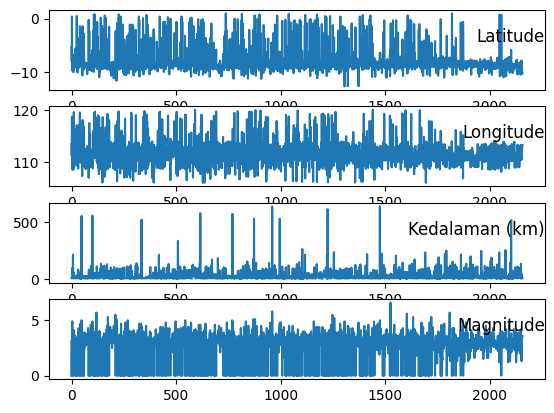

In [186]:
# load dataset
dataset = read_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022clean.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [187]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [188]:
# Load dataset
dataset = read_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022clean.csv')
# Select relevant columns
data = dataset[['Latitude', 'Longitude', 'Kedalaman (km)', 'Magnitude']]
values = data.values
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Specify the number of lag hours
n_day = 30
n_features = 4  # Number of columns in the data
# Frame as supervised learning
reframed = series_to_supervised(scaled, n_day, 1)
print(reframed.shape)

(2128, 124)


In [189]:
# Split into train and test sets
values = reframed.values
n_train_day = 365
train = values[:n_train_day, :]
test = values[n_train_day:, :]

In [190]:
# Split into input and outputs
n_obs = n_day * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 120) (365,) (1763, 120) (1763,)


In [191]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_day, n_features))
test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 30, 4) (365,) (1763, 30, 4) (1763,)


In [192]:
# Design network
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# Third LSTM layer
model.add(LSTM(units=32,activation='relu', return_sequences=True))
# Fourth LSTM layer
model.add(LSTM(units=16, activation='relu'))
# The output layer
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

In [193]:
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/50
6/6 [==============================] - 4s 263ms/step - loss: 0.3659 - val_loss: 0.3442
Epoch 2/50
6/6 [==============================] - 1s 203ms/step - loss: 0.3151 - val_loss: 0.2374
Epoch 3/50
6/6 [==============================] - 1s 204ms/step - loss: 0.2333 - val_loss: 0.1633
Epoch 4/50
6/6 [==============================] - 1s 202ms/step - loss: 0.2027 - val_loss: 0.1688
Epoch 5/50
6/6 [==============================] - 1s 201ms/step - loss: 0.2019 - val_loss: 0.1485
Epoch 6/50
6/6 [==============================] - 1s 203ms/step - loss: 0.1883 - val_loss: 0.1436
Epoch 7/50
6/6 [==============================] - 1s 208ms/step - loss: 0.1885 - val_loss: 0.1437
Epoch 8/50
6/6 [==============================] - 1s 202ms/step - loss: 0.1875 - val_loss: 0.1404
Epoch 9/50
6/6 [==============================] - 1s 222ms/step - loss: 0.1849 - val_loss: 0.1406
Epoch 10/50
6/6 [==============================] - 1s 218ms/step - loss: 0.1856 - val_loss: 0.1406
Epoch 11/50
6/6 [==

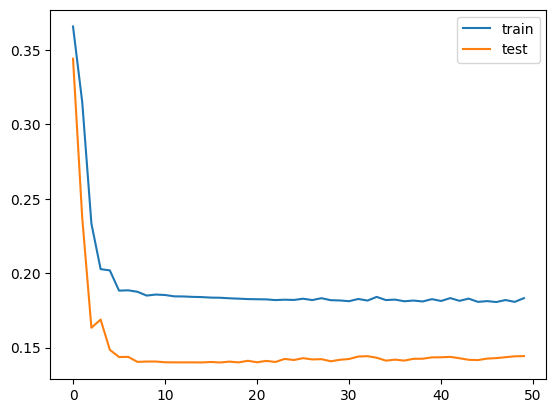

In [194]:
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [195]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_day*n_features))

56/56 [==============================] - 1s 14ms/step


In [196]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

ValueError: operands could not be broadcast together with shapes (1763,5) (4,) (1763,5) 

In [ ]:
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

In [ ]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)